In [1]:
import pickle
from itertools import groupby
from operator import itemgetter

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import config

### Read Data and Model

In [2]:
# read in data
data = pd.read_csv(config.PREPARED_DATA_PATH_EVAL_SESSION, compression = 'gzip')

# read in holdout user id to traintest split
with open(config.HOLD_OUT_USER_ID_PATH_EVAL_SESSION, 'rb') as file:
    hold_out_user_id = pickle.load(file)

# read in model
with open(config.MODEL_PATH_EVAL_SESSION, 'rb') as file:
    model = pickle.load(file) 

# read in model features
with open(config.MODEL_FEATURES_PATH_EVAL_SESSION, 'rb') as file:
    model_features = pickle.load(file) 

### Prepare Train and Test Data

In [3]:
testing = data[data['user_id'].isin(hold_out_user_id)]
X = testing.drop(['reached','user_id','session_id'], axis = 1)
y = testing['reached']
#add missing feature
for new_col in np.setdiff1d(model_features,X.columns):
    X[new_col] = np.nan 
#reorder 
X = X.reindex(model_features, axis=1)

# calculate probs
probability = pd.DataFrame(model.predict_proba(X))

# get testing data with probs
testing.reset_index(drop = True, inplace = True)
testing.loc[:,'prob'] = probability.loc[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
training = data[~data['user_id'].isin(hold_out_user_id)]
X = training.drop(['reached','user_id','session_id'], axis = 1)
y = training['reached']
#add missing feature
for new_col in np.setdiff1d(model_features,X.columns):
    X[new_col] = np.nan 
#reorder 
X = X.reindex(model_features, axis=1)

# calculate probs
probability = pd.DataFrame(model.predict_proba(X))

# get testing data with probs
training.reset_index(drop = True, inplace = True)
training.loc[:,'prob'] = probability.loc[:,1]

### Finding Rules

In [5]:
x_size = 10
y_size = 10
fig_size = (25,25)
skip_num = 200

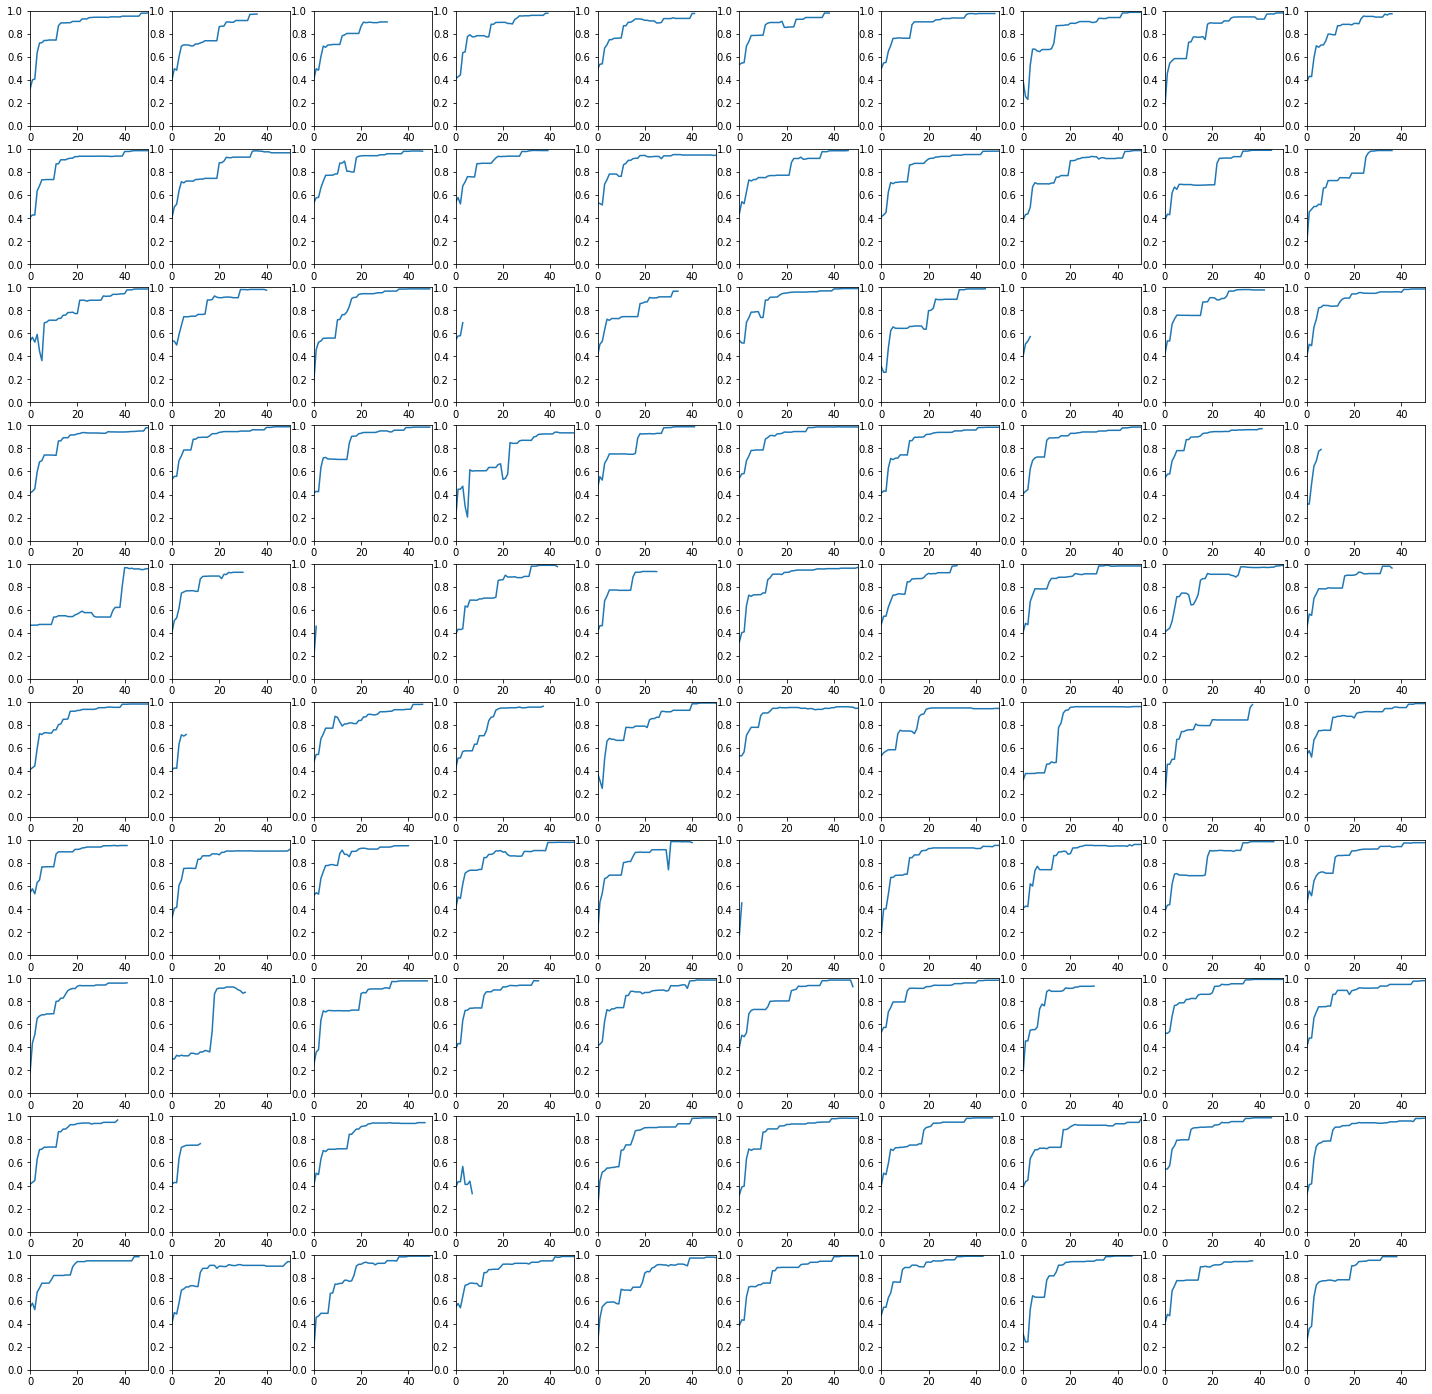

In [6]:
fig, axes = plt.subplots(x_size,y_size,figsize = fig_size)
num = 0
for i,session in enumerate(training['session_id'].unique()):
    if i<skip_num:
        continue
    session_prob = list(training[training['session_id'] == session]['prob'])
    session_result = training[training['session_id'] == session]['reached'].iloc[0]
    if session_result == 1:
        axes[num//x_size][num%y_size].plot(session_prob)
        axes[num//x_size][num%y_size].set_ylim(0,1)
        axes[num//x_size][num%y_size].set_xlim(0,50)
        num += 1
    
    if num >= x_size*y_size:
        break

plt.show()

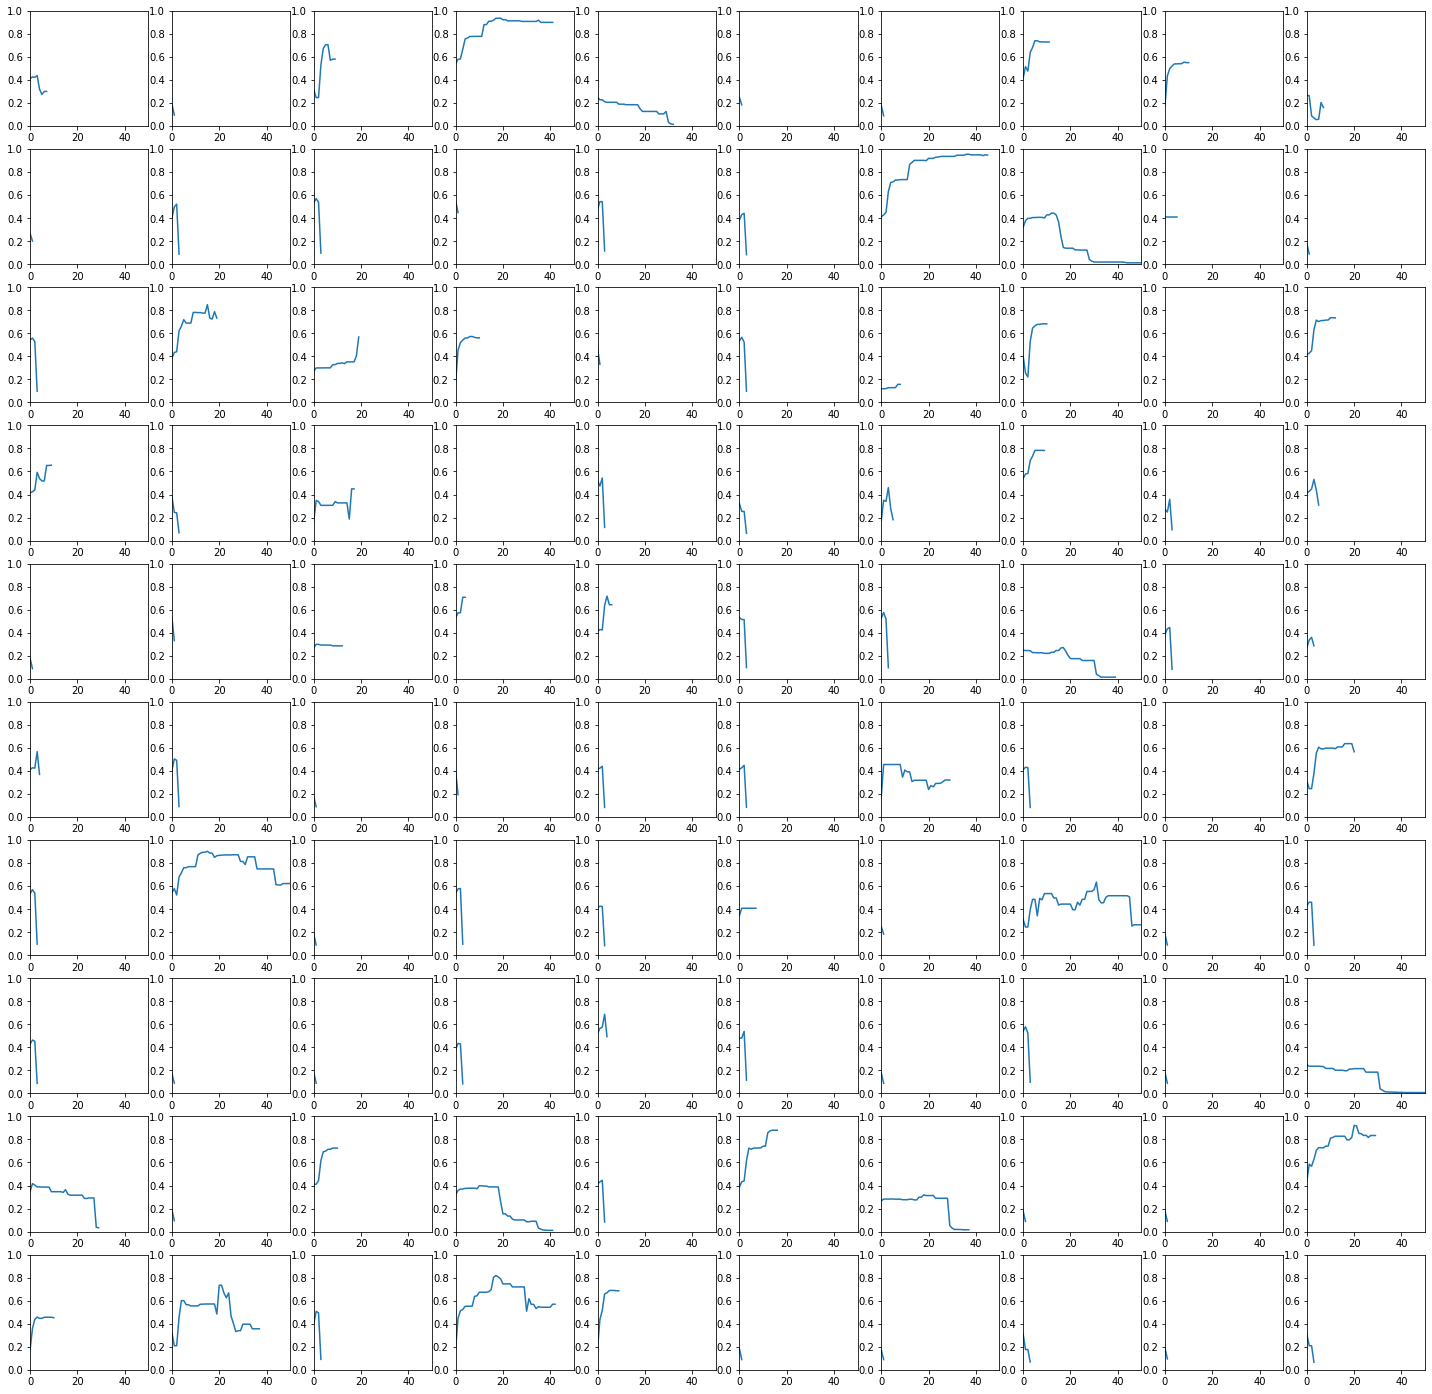

In [7]:
fig, axes = plt.subplots(x_size,y_size,figsize = fig_size)
num = 0
for i,session in enumerate(training['session_id'].unique()):
    if i<skip_num:
        continue
    session_prob = list(training[training['session_id'] == session]['prob'])
    session_result = training[training['session_id'] == session]['reached'].iloc[0]
    if session_result == 0:
        axes[num//x_size][num%y_size].plot(session_prob)
        axes[num//x_size][num%y_size].set_ylim(0,1)
        axes[num//x_size][num%y_size].set_xlim(0,50)
        num += 1
    
    if num >= x_size*y_size:
        break

plt.show()

### Define Rule

In [8]:
def intervene_decision(probs):
    intervene = 0
    probs_delta = [(probs[e], probs[e]-probs[e-1]) for e in range(1,len(probs))]
        
    # if drop to under .25 then intervene
    if any(e for e in probs_delta if e[0]<0.25 and e[1]<0):
        intervene = 1
        
    # if drop more than .15 then intervene
    accumulate_drop = 0
    for e in probs_delta:
        if e[1] > 0.05:
            accumulate_drop = 0
        if e[1] <= 0.05:
            accumulate_drop += e[1]
        if accumulate_drop < -0.2:
            intervene = 1
            break
            
    # if after 5 step not higher than 50% then intervene
    if len(probs) > 5:
        if probs[4]<0.5:
            intervene = 1
    
    # if after 20 not reached to .70 then intervene
    if len(probs) > 20:
        if probs[19]<0.7:
            intervene = 1
    
    return intervene

### Testing on Train

In [9]:
tn = 0
tp = 0
fp = 0
fn = 0
session_ttl_num = len(training['session_id'].unique())

for i,session in enumerate(training['session_id'].unique()):
    
    if i%5000 == 0:
        print('{}/{} completed.'.format(i, session_ttl_num))
    
    session_prob = list(training[training['session_id'] == session]['prob'])
    session_result = training[training['session_id'] == session]['reached'].iloc[0]
    decision = intervene_decision(session_prob)
    
    if session_result == 1:
        if decision == 1:
            fp += 1
        else:
            tn += 1
    else:
        if decision == 1:
            tp += 1
        else:
            fn += 1

precision = tp/(fp+tp)
recall = tp/(tp+fn)

print('Precision:{}'.format(precision))
print('Recall:{}'.format(recall))

0/26938 completed.
5000/26938 completed.
10000/26938 completed.
15000/26938 completed.
20000/26938 completed.
25000/26938 completed.
Precision:0.8942833123160993
Recall:0.7356076759061834


### Testing on Test

In [10]:
tn = 0
tp = 0
fp = 0
fn = 0

for session in testing['session_id'].unique():
    session_prob = list(testing[testing['session_id'] == session]['prob'])
    session_result = testing[testing['session_id'] == session]['reached'].iloc[0]
    decision = intervene_decision(session_prob)
    
    if session_result == 1:
        if decision == 1:
            fp += 1
        else:
            tn += 1
    else:
        if decision == 1:
            tp += 1
        else:
            fn += 1

precision = tp/(fp+tp)
recall = tp/(tp+fn)

print('Precision:{}'.format(precision))
print('Recall:{}'.format(recall))

Precision:0.8788965517241379
Recall:0.7213040525243378


In [11]:
tn, tp, fp, fn

(1903, 3186, 439, 1231)